In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_auc_score,plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport


In [2]:
pwd

'/Users/andrewstephens/Final_project/Modeling'

In [3]:
cd ..

/Users/andrewstephens/Final_project


In [4]:
df = pd.read_csv('Data/Preprocessing.csv',index_col=0)
df.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y,job_admin.,job_blue-collar,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,93.994,-36.4,5191.0,no,1,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0


# Making Sure Data is Balanced 



We will be using the undersampling strategy, however,we first must break df into X and y to then split again into test and train sets. 

In [5]:
X=df.drop(['y',"y_yes","y_no"], axis=1)
y=df['y']



In [ ]:
#Underfitting did not work as well as overfitting. Models were not running as highly. 

In [6]:
# summarize class distribution

print("Before oversampling: ", Counter(y))

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)



# fit and apply the transform
X, y = oversample.fit_resample(X, y)


# summarize class distribution

print("After oversampling: ", Counter(y))

Before undersampling:  Counter({'no': 36548, 'yes': 4640})
After undersampling:  Counter({'no': 36548, 'yes': 36548})


In [7]:
print(Counter(y))

Counter({'no': 36548, 'yes': 36548})


In [8]:
# Looks like our data is balanced

# Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [10]:
# normalize data 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [11]:
X_train.shape, y_train.shape 

((58476, 60), (58476,))

In [12]:
print(y_train)

30429     no
6880      no
67952    yes
2058      no
40221    yes
        ... 
49100    yes
20609     no
21440     no
50057    yes
5192      no
Name: y, Length: 58476, dtype: object


# Model Creation

We will be starting with KNN, a unsupervised learning method, because its versatile, simple, accurate and non assumpitve. Choosing K parameter will be most important, as it may cause overfitting if we are not careful. 

# KNN 

In [14]:
# pipeline combining transformers and estimator
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())

In [15]:
# grid searh to choose the best (combination of) hyperparameters
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[5,6,7]},
               scoring='accuracy',
               cv=5)


In [16]:



# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_knn_scores = cross_val_score(gs_knn, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)



In [17]:
# fit, and fit with best estimator
gs_knn.fit(X_train, y_train)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [18]:
print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(X_test, y_test)*100))


Train Accuracy:   94.3%
Test Accuracy:    92.3%


In [19]:
#confusion_matrix and classification report
ypreds=gs_knn_best.predict(X_test)
print(classification_report(y_test,ypreds))



              precision    recall  f1-score   support

          no       0.92      0.92      0.92      7369
         yes       0.92      0.92      0.92      7251

    accuracy                           0.92     14620
   macro avg       0.92      0.92      0.92     14620
weighted avg       0.92      0.92      0.92     14620



In [20]:
#confusion matrix 

Confusion matrix, without normalization
[[6812  557]
 [ 576 6675]]
Normalized confusion matrix
[[0.92441308 0.07558692]
 [0.07943732 0.92056268]]


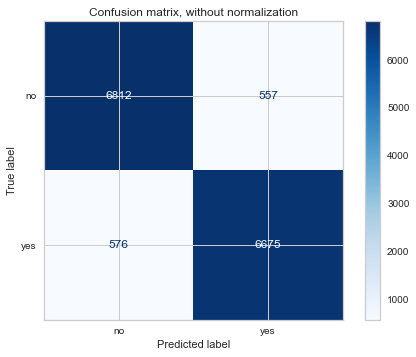

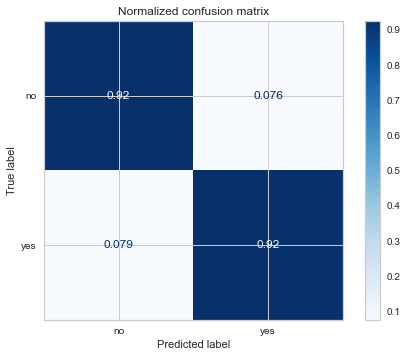

In [21]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


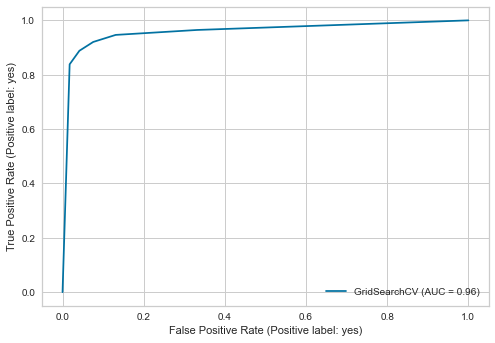

In [22]:
KNN_score = plot_roc_curve(gs_knn, X_test, y_test)

* 37% FP and 21%FN, AUC 75% with undersampling
* FP= 7.9% FN= 7.6%, AUC 96% AUC with oversampling 

Looks really good ! Now lets try Logistic Regression. 

# Logistic Regression 

In [23]:
lr = LogisticRegressionCV(random_state=1, max_iter =1000)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [24]:
test_accuracy = accuracy_score(y_test,preds)
print(test_accuracy)

0.9391928864569083


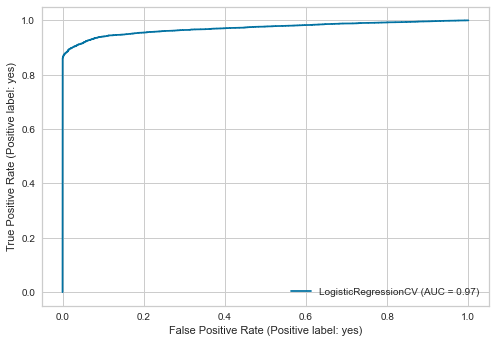

In [25]:
lr_roc = plot_roc_curve(lr, X_test, y_test)

Confusion matrix, without normalization
[[7239  130]
 [ 759 6492]]
Normalized confusion matrix
[[0.98235853 0.01764147]
 [0.10467522 0.89532478]]


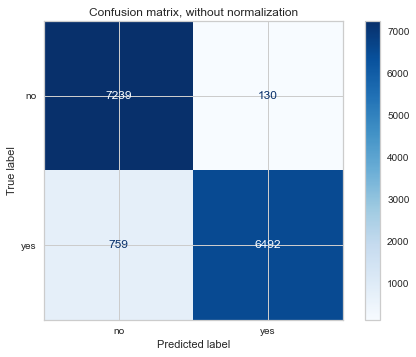

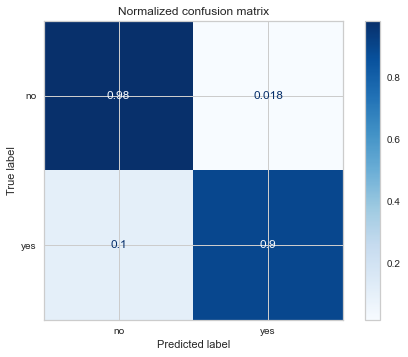

In [26]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


* FP 38% FN 14% AUC 80% with undersampling 
* FP 1% FN .018, AUC 97% with oversampling 

# SVM 

A support vector machine is a machine learning model that is able to generalise between two different classes if the set of labelled data is provided in the training set to the algorithm. The main function of the SVM is to check for that hyperplane that is able to distinguish between the two classes.[1]

In [40]:
# pipeline combining transformers and estimator
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1]
pg_svm=[ {'svc__C':r, 'svc__gamma':r}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=3)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=3,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(X_test, y_test)*100))

Train Accuracy:   97.2%
Test Accuracy:    93.3%


In [41]:
#confusion_matrix and classification report
ypreds=gs_svm_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))



[[7192  177]
 [ 798 6453]]
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      7369
         yes       0.97      0.89      0.93      7251

    accuracy                           0.93     14620
   macro avg       0.94      0.93      0.93     14620
weighted avg       0.94      0.93      0.93     14620



Confusion matrix, without normalization
[[7192  177]
 [ 798 6453]]
Normalized confusion matrix
[[0.97598046 0.02401954]
 [0.11005379 0.88994621]]


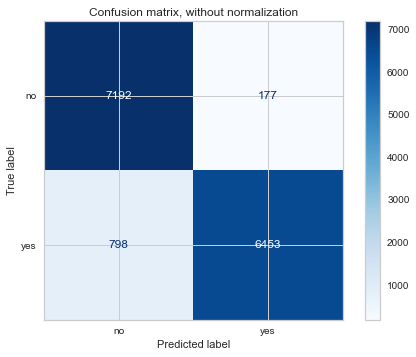

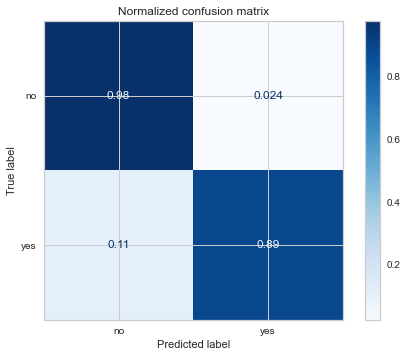

In [42]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_svm, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


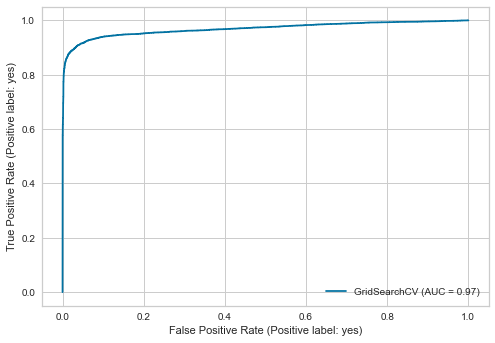

In [43]:
#ROC plot 
svm_plot = plot_roc_curve(gs_svm, X_test, y_test)

* FP=29%,FN=32%,AUC=74% with undersampling
* FP FN AUC with oversampling 

# Random Forest

In [29]:
rf= RandomForestClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_rf={'n_estimators': [100,250,400],'max_depth': [10,20,40,50,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=5)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_rf_scores = cross_val_score(gs_rf, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_rf.fit(X_train, y_train)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(X_test, y_test)*100))

Train Accuracy:   99.6%
Test Accuracy:    94.0%


In [30]:
#confusion_matrix and classification report
ypreds=gs_rf_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))



[[6996  373]
 [ 507 6744]]
              precision    recall  f1-score   support

          no       0.93      0.95      0.94      7369
         yes       0.95      0.93      0.94      7251

    accuracy                           0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620



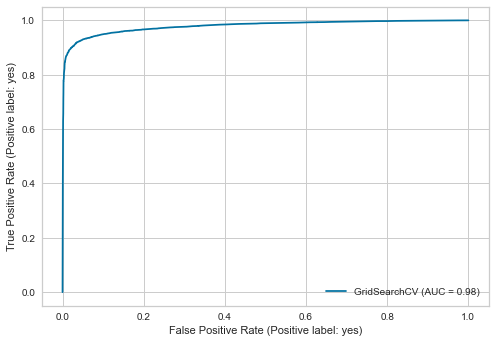

In [31]:
rf_roc = plot_roc_curve(gs_rf, X_test, y_test)

In [32]:
X_train.shape

(58476, 60)

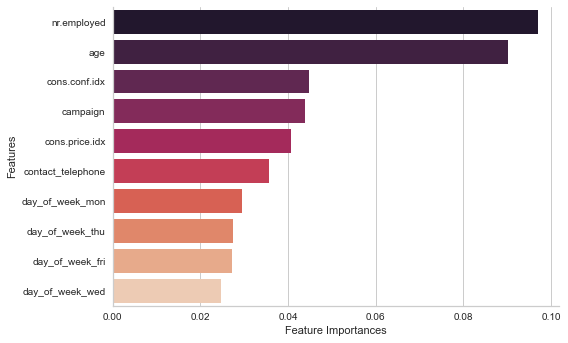

In [33]:
# using random forest to get feature importances
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

It looks like employees plays the biggest factor with how many employees are there to make the calls.Volume is another factor, because we can see how important the number of employees to carry through the campaign is.Any decrease in the workforce suggests that would have negative effects to the campaign. Age also seems to be a factor,but that is no surprise because the younger they can get a client, the longer they can do business with them over the course of their life.Consumer confidence plays a factor due to its relationship with consumers and how well they believe the economy is doing. The better the economy the more likely the customer will take a loan because good economy equals stable work for most.                                                                                                                                                              


Confusion matrix, without normalization
[[6996  373]
 [ 507 6744]]
Normalized confusion matrix
[[0.94938255 0.05061745]
 [0.06992139 0.93007861]]


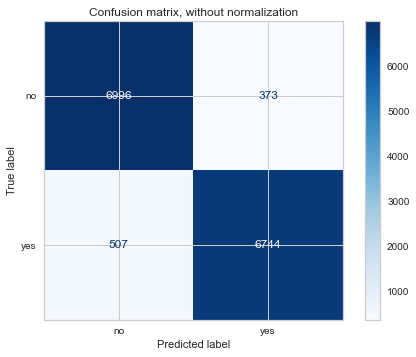

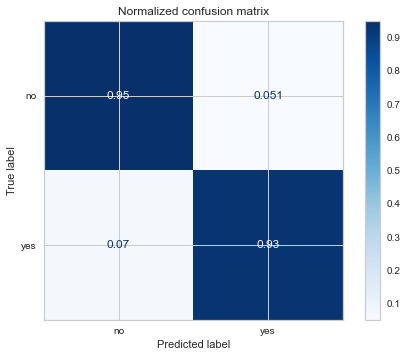

In [34]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


* FP=37%,FN=13%,AUC =80% with undersampling 
* FP= 7% ,FN=5.1%, AUC=98% with oversampling  

# Gradient Boosting 


In [35]:
# estimator
xb= xgb.XGBClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_xb={'n_estimators':[150,200,400], 'max_depth':[5,10,20,30],'min_child_weight':[.25,.5,.75]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=5)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_xb_scores = cross_val_score(gs_xb, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_xb.fit(X_train, y_train)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(X_test, y_test)*100))


Train Accuracy:   95.5%
Test Accuracy:    94.0%


In [36]:
# using random forest results: confusion_matrix and classification report
ypreds=gs_xb_best.predict(X_test)
print(confusion_matrix(y_test,ypreds))
print(classification_report(y_test,ypreds))


[[7152  217]
 [ 661 6590]]
              precision    recall  f1-score   support

          no       0.92      0.97      0.94      7369
         yes       0.97      0.91      0.94      7251

    accuracy                           0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620



Confusion matrix, without normalization
[[7152  217]
 [ 661 6590]]
Normalized confusion matrix
[[0.97055231 0.02944769]
 [0.09115984 0.90884016]]


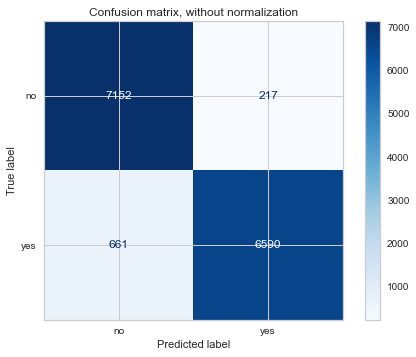

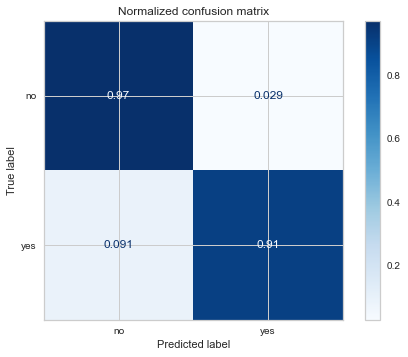

In [37]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_xb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

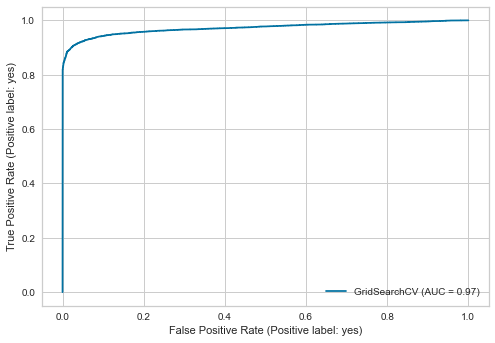

In [38]:
gb_roc = plot_roc_curve(gs_xb, X_test, y_test)

* FP=36%,FN=18%,AUC=78% with undersampling 
* FP=9.1% ,FN= 2.9%, AUC=97% with oversampling 

the model we choose will be XGboost because the test accuracy is the among highest as well as the fp rate being the best 

Reference #1  https://www.analyticssteps.com/blogs/how-does-support-vector-machine-algorithm-works-machine-learning 

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/